Imports

In [1]:
import math
import numpy as np
import tensorflow
from tensorflow.keras.datasets import mnist, cifar10, fashion_mnist, cifar100

Load MNIST Data

In [2]:
(training_data,training_labels),(testing_data,testing_labels) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


Use 25% of data for hyper-parameter tuning

In [3]:
training_data = training_data[:15000,:,:]
training_labels = training_labels[:15000]
testing_data = testing_data[:2500,:,:]
testing_labels = testing_labels[:2500]

Re-shape data and labels arrays

In [4]:
training_data = training_data.reshape((training_data.shape[0],28,28,1))
training_labels = training_labels[:, np.newaxis]
testing_data = testing_data.reshape((testing_data.shape[0],28,28,1))
testing_labels = testing_labels[:, np.newaxis]
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(15000, 28, 28, 1) (15000, 1) (2500, 28, 28, 1) (2500, 1)


Pre-processing

In [5]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [6]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

In [7]:
from tensorflow.keras.utils import to_categorical

nclasses = 10

# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

Dividing the training data to get validation set

In [8]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(13500, 28, 28, 1) (1500, 28, 28, 1) (13500, 10) (1500, 10)


Implementation of LeNet-5 Architecture

In [49]:
from tensorflow.keras.layers import Dense, Conv2D, Input, AveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

class LeNet5:

    def __init__(self, nclasses=10) -> None:
       
        self.input_layer = Input(shape=(training_data.shape[1],training_data.shape[2],training_data.shape[3]))

        self.convolution_1_layer = Conv2D(filters=6, kernel_size=(5,5), strides=1, padding='same', activation='tanh')(self.input_layer)
        self.avgpool_1_layer = AveragePooling2D(pool_size=(2,2), strides=2, padding='same')(self.convolution_1_layer)

        self.convolution_2_layer = Conv2D(filters=16, kernel_size=(5,5), strides=1, padding='same', activation='tanh')(self.avgpool_1_layer)
        self.avgpool_2_layer = AveragePooling2D(pool_size=(2,2), strides=2, padding='same')(self.convolution_2_layer)

        self.convolution_3_layer = Conv2D(filters=120, kernel_size=(5,5), strides=1, padding='same', activation='tanh')(self.avgpool_2_layer)

        self.fc_layer = Flatten()(self.convolution_3_layer)
        self.fc_layer = Dense(units=84, activation='tanh')(self.fc_layer)

        self.output_layer = Dense(units=nclasses, activation='softmax')(self.fc_layer)

        self.model = Model(inputs=self.input_layer, outputs=self.output_layer)

In [10]:
model_hpt_epoch = LeNet5().model
model_hpt_epoch.compile(
    optimizer=optimizers.SGD(
        learning_rate=0.01,
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_hpt_epoch.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 7, 7, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 120)         48120 

In [11]:
train_hist = []

In [12]:
hist = model_hpt_epoch.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=50, batch_size=128)
train_hist.append(hist)

Epoch 1/50
106/106 [==============================] - 10s 10ms/step - loss: 0.8610 - accuracy: 0.7647 - val_loss: 0.3682 - val_accuracy: 0.8927
Epoch 2/50
106/106 [==============================] - 1s 5ms/step - loss: 0.2953 - accuracy: 0.9130 - val_loss: 0.3020 - val_accuracy: 0.9100
Epoch 3/50
106/106 [==============================] - 1s 5ms/step - loss: 0.2306 - accuracy: 0.9338 - val_loss: 0.2553 - val_accuracy: 0.9253
Epoch 4/50
106/106 [==============================] - 1s 5ms/step - loss: 0.1925 - accuracy: 0.9447 - val_loss: 0.2287 - val_accuracy: 0.9327
Epoch 5/50
106/106 [==============================] - 1s 5ms/step - loss: 0.1669 - accuracy: 0.9504 - val_loss: 0.2038 - val_accuracy: 0.9393
Epoch 6/50
106/106 [==============================] - 1s 5ms/step - loss: 0.1466 - accuracy: 0.9576 - val_loss: 0.1934 - val_accuracy: 0.9387
Epoch 7/50
106/106 [==============================] - 1s 5ms/step - loss: 0.1320 - accuracy: 0.9616 - val_loss: 0.1706 - val_accuracy: 0.9520
Epoc

In [13]:
import matplotlib.pyplot as plt

def showLossAccPlots2(train_hist):
    
    training_acc = []
    validate_acc = []
    train_losses = []
    validate_losses = []
    
    for th in train_hist:
        train_losses += th.history['loss']
        validate_losses += th.history['val_loss']
        training_acc += th.history['accuracy']
        validate_acc += th.history['val_accuracy']
    
    fig, (ax1, ax2) = plt.subplots(2, 1)

    epochs = range(1, len(training_acc) + 1)

    fig.suptitle('Losses and Accuracies across epochs')

    ax1.plot(epochs, train_losses, 'b', label='Training Loss')
    ax1.plot(epochs, validate_losses, 'r', label='Validation Loss')
    ax1.set_ylabel('Losses')
    ax1.legend()

    ax2.plot(epochs, training_acc, 'b', label='Train accuracy')
    ax2.plot(epochs, validate_acc, 'r', label='Validate accuracy')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('Accuracies')
    ax2.legend()

    plt.show()


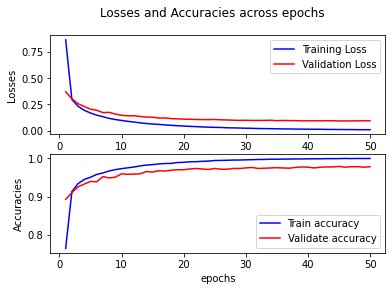

In [14]:
showLossAccPlots2(train_hist)

As we can see, beyond 20 epcohs, validation accuracy shows no significant change. In fact, validation accuracy fluctuates after 20th epoch, but training accuracy continues to slightly increase, which suggests overfitting. Hence, we set the number of epochs = 20.

In [15]:
epochs = 20

In [16]:
learning_rates = [0.001, 0.01, 0.1]

model_hpt_lr0 = LeNet5().model
model_hpt_lr0.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[0],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [17]:
train_hist = []
hist = model_hpt_lr0.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=128)
train_hist.append(hist)

Epoch 1/20
106/106 [==============================] - 1s 8ms/step - loss: 2.1879 - accuracy: 0.4159 - val_loss: 1.9458 - val_accuracy: 0.6547
Epoch 2/20
106/106 [==============================] - 1s 6ms/step - loss: 1.3691 - accuracy: 0.7119 - val_loss: 0.9165 - val_accuracy: 0.7813
Epoch 3/20
106/106 [==============================] - 1s 5ms/step - loss: 0.7098 - accuracy: 0.8195 - val_loss: 0.6436 - val_accuracy: 0.8287
Epoch 4/20
106/106 [==============================] - 1s 5ms/step - loss: 0.5435 - accuracy: 0.8552 - val_loss: 0.5420 - val_accuracy: 0.8513
Epoch 5/20
106/106 [==============================] - 1s 5ms/step - loss: 0.4699 - accuracy: 0.8721 - val_loss: 0.4855 - val_accuracy: 0.8633
Epoch 6/20
106/106 [==============================] - 1s 5ms/step - loss: 0.4239 - accuracy: 0.8837 - val_loss: 0.4515 - val_accuracy: 0.8693
Epoch 7/20
106/106 [==============================] - 1s 6ms/step - loss: 0.3931 - accuracy: 0.8888 - val_loss: 0.4218 - val_accuracy: 0.8760
Epoch 

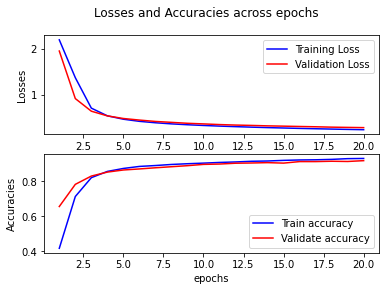

In [18]:
showLossAccPlots2(train_hist)

In [19]:
model_hpt_lr1 = LeNet5().model
model_hpt_lr1.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[1],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [20]:
train_hist = []
hist = model_hpt_lr1.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=128)
train_hist.append(hist)

Epoch 1/20
106/106 [==============================] - 1s 8ms/step - loss: 0.8779 - accuracy: 0.7496 - val_loss: 0.3803 - val_accuracy: 0.8887
Epoch 2/20
106/106 [==============================] - 1s 5ms/step - loss: 0.3042 - accuracy: 0.9101 - val_loss: 0.2972 - val_accuracy: 0.9133
Epoch 3/20
106/106 [==============================] - 1s 5ms/step - loss: 0.2361 - accuracy: 0.9295 - val_loss: 0.2537 - val_accuracy: 0.9207
Epoch 4/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1973 - accuracy: 0.9421 - val_loss: 0.2232 - val_accuracy: 0.9340
Epoch 5/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1713 - accuracy: 0.9501 - val_loss: 0.2067 - val_accuracy: 0.9447
Epoch 6/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1513 - accuracy: 0.9563 - val_loss: 0.1907 - val_accuracy: 0.9387
Epoch 7/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1354 - accuracy: 0.9608 - val_loss: 0.1888 - val_accuracy: 0.9493
Epoch 

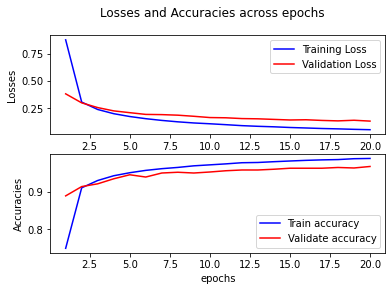

In [21]:
showLossAccPlots2(train_hist)

In [22]:
model_hpt_lr2 = LeNet5().model
model_hpt_lr2.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[2],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [23]:
train_hist = []
hist = model_hpt_lr2.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=128)
train_hist.append(hist)

Epoch 1/20
106/106 [==============================] - 1s 8ms/step - loss: 0.4748 - accuracy: 0.8554 - val_loss: 0.2489 - val_accuracy: 0.9273
Epoch 2/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1802 - accuracy: 0.9438 - val_loss: 0.2021 - val_accuracy: 0.9380
Epoch 3/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1405 - accuracy: 0.9559 - val_loss: 0.1783 - val_accuracy: 0.9520
Epoch 4/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1086 - accuracy: 0.9659 - val_loss: 0.1674 - val_accuracy: 0.9553
Epoch 5/20
106/106 [==============================] - 1s 5ms/step - loss: 0.0867 - accuracy: 0.9728 - val_loss: 0.1502 - val_accuracy: 0.9613
Epoch 6/20
106/106 [==============================] - 1s 5ms/step - loss: 0.0694 - accuracy: 0.9776 - val_loss: 0.1478 - val_accuracy: 0.9580
Epoch 7/20
106/106 [==============================] - 1s 5ms/step - loss: 0.0627 - accuracy: 0.9795 - val_loss: 0.1434 - val_accuracy: 0.9607
Epoch 

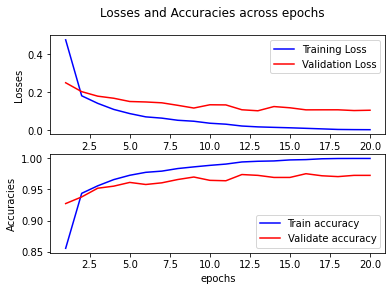

In [24]:
showLossAccPlots2(train_hist)

We can see that lr=0.1 yields the best performance on the validation, and also fits the training data very well. Hence we set learning rate = 0.1

In [25]:
learning_rate = 0.1

In [26]:
momentums = [0.9, 0.75, 0.6]

model_hpt_mt0 = LeNet5().model
model_hpt_mt0.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[0]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [27]:
train_hist = []
hist = model_hpt_mt0.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=128)
train_hist.append(hist)

Epoch 1/20
106/106 [==============================] - 1s 8ms/step - loss: 0.4594 - accuracy: 0.8545 - val_loss: 0.2552 - val_accuracy: 0.9273
Epoch 2/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1865 - accuracy: 0.9441 - val_loss: 0.2209 - val_accuracy: 0.9280
Epoch 3/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1385 - accuracy: 0.9590 - val_loss: 0.2011 - val_accuracy: 0.9460
Epoch 4/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1147 - accuracy: 0.9643 - val_loss: 0.1718 - val_accuracy: 0.9480
Epoch 5/20
106/106 [==============================] - 1s 5ms/step - loss: 0.0959 - accuracy: 0.9685 - val_loss: 0.1557 - val_accuracy: 0.9600
Epoch 6/20
106/106 [==============================] - 1s 5ms/step - loss: 0.0697 - accuracy: 0.9787 - val_loss: 0.1603 - val_accuracy: 0.9573
Epoch 7/20
106/106 [==============================] - 1s 5ms/step - loss: 0.0657 - accuracy: 0.9806 - val_loss: 0.1421 - val_accuracy: 0.9647
Epoch 

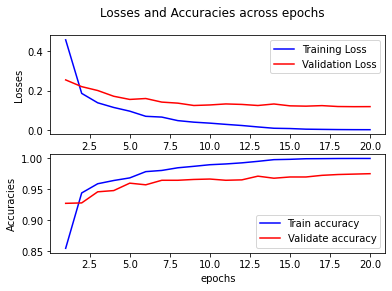

In [28]:
showLossAccPlots2(train_hist)

In [29]:
model_hpt_mt1 = LeNet5().model
model_hpt_mt1.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[1]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [30]:
train_hist = []
hist = model_hpt_mt1.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=128)
train_hist.append(hist)

Epoch 1/20
106/106 [==============================] - 1s 8ms/step - loss: 0.4967 - accuracy: 0.8441 - val_loss: 0.2561 - val_accuracy: 0.9213
Epoch 2/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1883 - accuracy: 0.9434 - val_loss: 0.2192 - val_accuracy: 0.9327
Epoch 3/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1376 - accuracy: 0.9587 - val_loss: 0.1687 - val_accuracy: 0.9520
Epoch 4/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1057 - accuracy: 0.9681 - val_loss: 0.1602 - val_accuracy: 0.9573
Epoch 5/20
106/106 [==============================] - 1s 5ms/step - loss: 0.0819 - accuracy: 0.9760 - val_loss: 0.1632 - val_accuracy: 0.9540
Epoch 6/20
106/106 [==============================] - 1s 5ms/step - loss: 0.0660 - accuracy: 0.9812 - val_loss: 0.1445 - val_accuracy: 0.9593
Epoch 7/20
106/106 [==============================] - 1s 5ms/step - loss: 0.0529 - accuracy: 0.9844 - val_loss: 0.1358 - val_accuracy: 0.9653
Epoch 

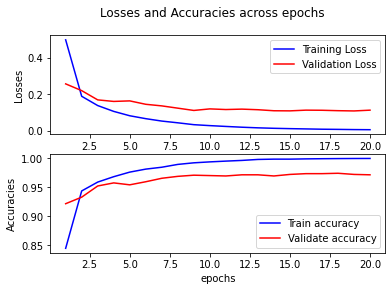

In [31]:
showLossAccPlots2(train_hist)

In [32]:
model_hpt_mt2 = LeNet5().model
model_hpt_mt2.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[2]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [33]:
train_hist = []
hist = model_hpt_mt2.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=128)
train_hist.append(hist)

Epoch 1/20
106/106 [==============================] - 1s 8ms/step - loss: 0.5268 - accuracy: 0.8408 - val_loss: 0.2885 - val_accuracy: 0.9167
Epoch 2/20
106/106 [==============================] - 1s 5ms/step - loss: 0.2100 - accuracy: 0.9368 - val_loss: 0.2293 - val_accuracy: 0.9300
Epoch 3/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1561 - accuracy: 0.9532 - val_loss: 0.1858 - val_accuracy: 0.9413
Epoch 4/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1251 - accuracy: 0.9633 - val_loss: 0.1648 - val_accuracy: 0.9547
Epoch 5/20
106/106 [==============================] - 1s 5ms/step - loss: 0.1028 - accuracy: 0.9699 - val_loss: 0.1449 - val_accuracy: 0.9627
Epoch 6/20
106/106 [==============================] - 1s 5ms/step - loss: 0.0890 - accuracy: 0.9736 - val_loss: 0.1423 - val_accuracy: 0.9600
Epoch 7/20
106/106 [==============================] - 1s 5ms/step - loss: 0.0736 - accuracy: 0.9784 - val_loss: 0.1309 - val_accuracy: 0.9653
Epoch 

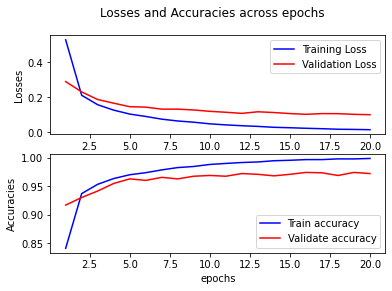

In [34]:
showLossAccPlots2(train_hist)

Here we see that the validation accuracy peaks for a momentum value = 0.75 and so we will set it accordingly.

In [35]:
momentum = 0.75

MNIST Dataset

In [72]:
(training_data,training_labels),(testing_data,testing_labels) = mnist.load_data()

In [73]:
training_data = training_data.reshape((training_data.shape[0],28,28,1))
training_labels = training_labels[:, np.newaxis]
testing_data = testing_data.reshape((testing_data.shape[0],28,28,1))
testing_labels = testing_labels[:, np.newaxis]
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(60000, 28, 28, 1) (60000, 1) (10000, 28, 28, 1) (10000, 1)


In [74]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [75]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [76]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [77]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (54000, 10) (6000, 10)


In [78]:
model_lenet5_mnist = LeNet5().model
model_lenet5_mnist.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_lenet5_mnist.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_20 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 14, 16)        2416      
                                                                 
 average_pooling2d_21 (Avera  (None, 7, 7, 16)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_32 (Conv2D)          (None, 7, 7, 120)         481

In [79]:
train_hist = []
hist = model_lenet5_mnist.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=128)
train_hist.append(hist)

Epoch 1/20
422/422 [==============================] - 3s 6ms/step - loss: 0.2476 - accuracy: 0.9249 - val_loss: 0.1231 - val_accuracy: 0.9642
Epoch 2/20
422/422 [==============================] - 2s 6ms/step - loss: 0.0928 - accuracy: 0.9721 - val_loss: 0.0728 - val_accuracy: 0.9793
Epoch 3/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0625 - accuracy: 0.9816 - val_loss: 0.0571 - val_accuracy: 0.9832
Epoch 4/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0470 - accuracy: 0.9856 - val_loss: 0.0569 - val_accuracy: 0.9843
Epoch 5/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0378 - accuracy: 0.9884 - val_loss: 0.0485 - val_accuracy: 0.9857
Epoch 6/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0320 - accuracy: 0.9904 - val_loss: 0.0437 - val_accuracy: 0.9872
Epoch 7/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0275 - accuracy: 0.9918 - val_loss: 0.0483 - val_accuracy: 0.9870
Epoch 

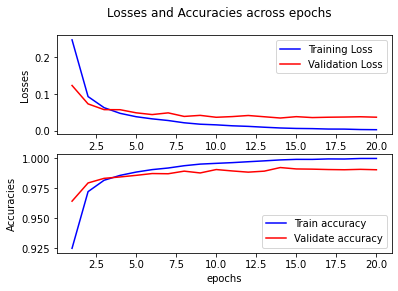

In [80]:
showLossAccPlots2(train_hist)

In [81]:
# Save the model
model_lenet5_mnist.save('LeNet5Mnist.h5')

In [82]:
model_lenet5_mnist.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=128,verbose=1)

79/79 [==============================] - 0s 3ms/step - loss: 0.0287 - accuracy: 0.9903


[0.028694622218608856, 0.9902999997138977]

Fashion-MNIST Dataset

In [83]:
(training_data,training_labels),(testing_data,testing_labels) = fashion_mnist.load_data()

In [84]:
training_data = training_data.reshape((training_data.shape[0],28,28,1))
testing_data = testing_data.reshape((testing_data.shape[0],28,28,1))
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [85]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [86]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [87]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [88]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (54000, 10) (6000, 10)


In [89]:
model_lenet5_fashion_mnist = LeNet5().model
model_lenet5_fashion_mnist.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_lenet5_fashion_mnist.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_22 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_34 (Conv2D)          (None, 14, 14, 16)        2416      
                                                                 
 average_pooling2d_23 (Avera  (None, 7, 7, 16)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_35 (Conv2D)          (None, 7, 7, 120)         481

In [90]:
train_hist = []
hist = model_lenet5_fashion_mnist.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=128)
train_hist.append(hist)

Epoch 1/20
422/422 [==============================] - 3s 6ms/step - loss: 0.5119 - accuracy: 0.8107 - val_loss: 0.3899 - val_accuracy: 0.8628
Epoch 2/20
422/422 [==============================] - 2s 5ms/step - loss: 0.3712 - accuracy: 0.8658 - val_loss: 0.3563 - val_accuracy: 0.8690
Epoch 3/20
422/422 [==============================] - 2s 5ms/step - loss: 0.3334 - accuracy: 0.8785 - val_loss: 0.3234 - val_accuracy: 0.8883
Epoch 4/20
422/422 [==============================] - 2s 5ms/step - loss: 0.3064 - accuracy: 0.8870 - val_loss: 0.3119 - val_accuracy: 0.8897
Epoch 5/20
422/422 [==============================] - 2s 5ms/step - loss: 0.2922 - accuracy: 0.8922 - val_loss: 0.3081 - val_accuracy: 0.8873
Epoch 6/20
422/422 [==============================] - 2s 5ms/step - loss: 0.2738 - accuracy: 0.8988 - val_loss: 0.2974 - val_accuracy: 0.8942
Epoch 7/20
422/422 [==============================] - 2s 5ms/step - loss: 0.2620 - accuracy: 0.9023 - val_loss: 0.2926 - val_accuracy: 0.8935
Epoch 

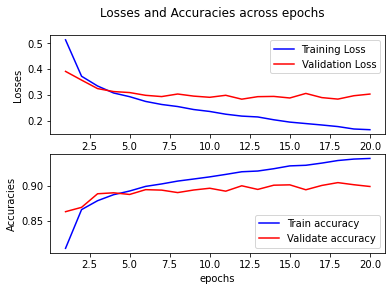

In [91]:
showLossAccPlots2(train_hist)

In [92]:
# Save the model
model_lenet5_fashion_mnist.save('LeNet5FashionMnist.h5')

In [93]:
model_lenet5_fashion_mnist.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=128,verbose=1)

79/79 [==============================] - 0s 3ms/step - loss: 0.3198 - accuracy: 0.8943


[0.3198106586933136, 0.8942999839782715]

CIFAR-100 Dataset

In [94]:
(training_data,training_labels),(testing_data,testing_labels) = cifar100.load_data()

169001437/169001437 [==============================] - 14s 0us/step


In [95]:
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [96]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [97]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [98]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [99]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (45000, 100) (5000, 100)


In [102]:
model_lenet5_cifar100 = LeNet5(nclasses=100).model
model_lenet5_cifar100.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_lenet5_cifar100.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d_26 (Avera  (None, 16, 16, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 16)        2416      
                                                                 
 average_pooling2d_27 (Avera  (None, 8, 8, 16)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 120)         481

In [103]:
train_hist = []
hist = model_lenet5_cifar100.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=128)
train_hist.append(hist)

Epoch 1/20
352/352 [==============================] - 3s 7ms/step - loss: 3.9768 - accuracy: 0.1026 - val_loss: 3.6790 - val_accuracy: 0.1436
Epoch 2/20
352/352 [==============================] - 2s 6ms/step - loss: 3.5774 - accuracy: 0.1676 - val_loss: 3.5132 - val_accuracy: 0.1678
Epoch 3/20
352/352 [==============================] - 2s 6ms/step - loss: 3.4358 - accuracy: 0.1906 - val_loss: 3.4670 - val_accuracy: 0.1810
Epoch 4/20
352/352 [==============================] - 2s 6ms/step - loss: 3.3489 - accuracy: 0.2047 - val_loss: 3.4234 - val_accuracy: 0.1812
Epoch 5/20
352/352 [==============================] - 2s 6ms/step - loss: 3.2838 - accuracy: 0.2159 - val_loss: 3.4880 - val_accuracy: 0.1824
Epoch 6/20
352/352 [==============================] - 2s 6ms/step - loss: 3.2485 - accuracy: 0.2212 - val_loss: 3.3988 - val_accuracy: 0.1938
Epoch 7/20
352/352 [==============================] - 2s 6ms/step - loss: 3.1902 - accuracy: 0.2314 - val_loss: 3.4023 - val_accuracy: 0.1964
Epoch 

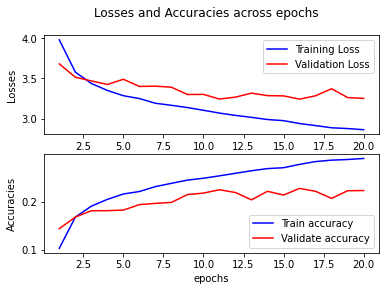

In [104]:
showLossAccPlots2(train_hist)

In [105]:
# Save the model
model_lenet5_cifar100.save('LeNet5Cifar100.h5')

In [106]:
model_lenet5_cifar100.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=128,verbose=1)

79/79 [==============================] - 1s 7ms/step - loss: 3.2492 - accuracy: 0.2377


[3.249224901199341, 0.23770000040531158]